# Roof detection using a pretrained Segnet model in pytorch

The goal is to detect roofs in aerial images with a neural network. The task is especially difficult because only for 25 pictures the ground truth in form of roof locations is provided. The performance of the neural network is supposed to be evaluated on five pictures, where no label information is given.

The chosen model for the task follows the [SegNet architecture](http://mi.eng.cam.ac.uk/projects/segnet/). This notebooks uses code that from https://github.com/nshaud/DeepNetsForEO/blob/master/SegNet_PyTorch_v2.ipynb where the segnet architecture was applied to segment roads, buildings, vegetation and cars. 

## Requirements

Requirements can be installed by running `pip install -r requirements.txt`.

The code was written to be run on a CPU. To run the code on a GPU and speed up the performance all
'.cuda()' commands which are currently commented out would have to be included again.

In [1]:
# imports and stuff
import numpy as np
from skimage import io
from skimage import color
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import random
import itertools
import os
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
import re

# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable


### Parameters
After thresholding the masks for the roof we have a binary classification problem for each single pixle, it is `black' or 'white'.
  * Binary classification: `N_CLASSES = 2`
The input color images have 4 dimensions but to used pretrained weight from the VGG16, the images are converted to the three channel format RGB. 
  
  * Number of input channels : `IN_CHANNELS = 3`
  

Retrieving training and test images. Only for the training images are labels available.

In [2]:
img_paths = glob(os.path.join('./images/', '*.png'))

img_name = []
test_img_name = []
for img_path in img_paths:    
    mask_path = img_path.replace('images', 'labels')
    if os.path.exists(mask_path):
        img_name.append(img_path)
    else:
        test_img_name.append(img_path)    

In [3]:
train_ids = []
for label in img_name:
    train_ids.append(re.findall(r'\d+', label)[0])

In [4]:
test_ids = []
for path in test_img_name:
    test_ids.append(re.findall(r'\d+', path)[0])

In [22]:
# Parameters
WINDOW_SIZE = (128, 128) # Patch size, to augment the data, training is performed on sections of the original images
STRIDE = 0 # set stride for testing, not used here
IN_CHANNELS = 3 # Number of input channels (here RGB)
BATCH_SIZE = 2 # Number of samples in a mini-batch
N_CLASSES = 2 # 'black' or 'white' after thresholding label pictures
WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
CACHE = True # Store the dataset in-memory

DATA_FOLDER = './images/{}.png'
LABEL_FOLDER = './labels/{}.png'


 Utility functions for cropping and calculating the loss and the accuracy:

In [17]:
def get_random_pos(img, window_shape):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h -1)
    y2 = y1 + h
    return x1, x2, y1, y2

def CrossEntropy2d(input, target, weight=None, size_average=True):
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target,weight, size_average)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk



We need to define a bunch of utils functions.

## Loading the dataset

We define a PyTorch dataset (```torch.utils.data.Dataset```) that loads all the tiles in memory and performs random sampling. Tiles are stored in memory on the fly.

The dataset also performs random data augmentation (horizontal and vertical flips).

In [7]:
# Dataset class

class Roof_dataset(torch.utils.data.Dataset):
    def __init__(self, ids, data_files=DATA_FOLDER, label_files=LABEL_FOLDER,
                            cache=False, augmentation=True):
        super(Roof_dataset, self).__init__()
        
        self.augmentation = augmentation
        self.cache = cache
        
        # List of files
        self.data_files = [DATA_FOLDER.format(id) for id in ids]
        self.label_files = [LABEL_FOLDER.format(id) for id in ids]
        print(self.data_files, self.label_files)

        # Sanity check : raise an error if some files do not exist
        for f in self.data_files + self.label_files:
            if not os.path.isfile(f):
                raise KeyError('{} is not a file !'.format(f))
        
        # Initialize cache dicts
        if self.cache:
            self.data_cache_ = {}
            self.label_cache_ = {}
            
    
    def __len__(self):
        # Default epoch size is 100 samples
        return 100
    
    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True
        
        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))
            
        return tuple(results)
    
    def __getitem__(self, i):
        # Pick a random image
        random_idx = random.randint(0, len(self.data_files) - 1)
        
        # If the tile hasn't been loaded yet, put in cache
        if random_idx in self.data_cache_.keys():
            data = self.data_cache_[random_idx]
        else:
            # Data is normalized in [0, 1]
            data = np.asarray(color.rgba2rgb(io.imread(self.data_files[random_idx])).transpose((2,0,1)), dtype='float32')
#             print('min', np.min(data), np.max(data))
            if self.cache:
                self.data_cache_[random_idx] = data
            
        if random_idx in self.label_cache_.keys():
            label = self.label_cache_[random_idx]
        else: 
            # Labels are converted from RGB to their numeric values
            label = np.asarray(io.imread(self.label_files[random_idx]), dtype='int64')
            label[label<=128] = 0
            label[label>128] = 1 
            if self.cache:
                self.label_cache_[random_idx] = label

        # Get a random patch
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
        label_p = label[x1:x2,y1:y2]
        
        # Data augmentation
        data_p, label_p = self.data_augmentation(data_p, label_p)
#         # Return the torch.Tensor values
        return (torch.from_numpy(data_p),
                torch.from_numpy(label_p))

## Network architecture

We can now define the CNN based on the SegNet architecture. The network can be adjusted but it is mandatory that the output dimensions (`W` and `H`) equal the input dimensions because for each input pixel should be determined if it is part of a roof. The output dimension of the network is `(N_CLASSES, W, H)` where N_CLASSES is two and corresponds to 0 ('other') or 1 ('roof').


In [8]:
class SegNet(nn.Module):
    # SegNet network
    @staticmethod
    def weight_init(m):
        """Initialization of weights according to He, K. et al."""
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal(m.weight.data)
    
    def __init__(self, in_channels=IN_CHANNELS, out_channels=N_CLASSES):
        super(SegNet, self).__init__()
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.conv1_1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(64)
        
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(128)
        
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(256)
        
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_bn = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_D_bn = nn.BatchNorm2d(512)
        self.conv5_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_D_bn = nn.BatchNorm2d(512)
        self.conv5_1_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_D_bn = nn.BatchNorm2d(512)
        
        self.conv4_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_D_bn = nn.BatchNorm2d(512)
        self.conv4_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_D_bn = nn.BatchNorm2d(512)
        self.conv4_1_D = nn.Conv2d(512, 256, 3, padding=1)
        self.conv4_1_D_bn = nn.BatchNorm2d(256)
        
        self.conv3_3_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_D_bn = nn.BatchNorm2d(256)
        self.conv3_2_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_D_bn = nn.BatchNorm2d(256)
        self.conv3_1_D = nn.Conv2d(256, 128, 3, padding=1)
        self.conv3_1_D_bn = nn.BatchNorm2d(128)
        
        self.conv2_2_D = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_D_bn = nn.BatchNorm2d(128)
        self.conv2_1_D = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2_1_D_bn = nn.BatchNorm2d(64)
        
        self.conv1_2_D = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_D_bn = nn.BatchNorm2d(64)
        self.conv1_1_D = nn.Conv2d(64, out_channels, 3, padding=1)
        
        self.apply(self.weight_init)
        
    def forward(self, x):
        # Encoder block 1
        x = self.conv1_1_bn(F.relu(self.conv1_1(x)))
        x = self.conv1_2_bn(F.relu(self.conv1_2(x)))
        # saving mask for every pooling operation, to be able to upsample the right values in the decoder part
        x, mask1 = self.pool(x)
        
        # Encoder block 2
        x = self.conv2_1_bn(F.relu(self.conv2_1(x)))
        x = self.conv2_2_bn(F.relu(self.conv2_2(x)))
        x, mask2 = self.pool(x)
        
        # Encoder block 3
        x = self.conv3_1_bn(F.relu(self.conv3_1(x)))
        x = self.conv3_2_bn(F.relu(self.conv3_2(x)))
        x = self.conv3_3_bn(F.relu(self.conv3_3(x)))
        x, mask3 = self.pool(x)
        
        # Encoder block 4
        x = self.conv4_1_bn(F.relu(self.conv4_1(x)))
        x = self.conv4_2_bn(F.relu(self.conv4_2(x)))
        x = self.conv4_3_bn(F.relu(self.conv4_3(x)))
        x, mask4 = self.pool(x)
        
        # Encoder block 5
        x = self.conv5_1_bn(F.relu(self.conv5_1(x)))
        x = self.conv5_2_bn(F.relu(self.conv5_2(x)))
        x = self.conv5_3_bn(F.relu(self.conv5_3(x)))
        x, mask5 = self.pool(x)
        
        # Decoder block 5
        x = self.unpool(x, mask5)
        x = self.conv5_3_D_bn(F.relu(self.conv5_3_D(x)))
        x = self.conv5_2_D_bn(F.relu(self.conv5_2_D(x)))
        x = self.conv5_1_D_bn(F.relu(self.conv5_1_D(x)))
        
        # Decoder block 4
        x = self.unpool(x, mask4)
        x = self.conv4_3_D_bn(F.relu(self.conv4_3_D(x)))
        x = self.conv4_2_D_bn(F.relu(self.conv4_2_D(x)))
        x = self.conv4_1_D_bn(F.relu(self.conv4_1_D(x)))
        
        # Decoder block 3
        x = self.unpool(x, mask3)
        x = self.conv3_3_D_bn(F.relu(self.conv3_3_D(x)))
        x = self.conv3_2_D_bn(F.relu(self.conv3_2_D(x)))
        x = self.conv3_1_D_bn(F.relu(self.conv3_1_D(x)))
        
        # Decoder block 2
        x = self.unpool(x, mask2)
        x = self.conv2_2_D_bn(F.relu(self.conv2_2_D(x)))
        x = self.conv2_1_D_bn(F.relu(self.conv2_1_D(x)))
        
        # Decoder block 1
        x = self.unpool(x, mask1)
        x = self.conv1_2_D_bn(F.relu(self.conv1_2_D(x)))
        x = F.log_softmax(self.conv1_1_D(x))
        return x

Instantiating the network using the specified parameters. By default, the weights will be initialized using the [He policy](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf).

In [9]:
# instantiate the network
net = SegNet()

Pre-trained weights from VGG-16 on ImageNet are downloaded. Since the data is sparse relying on pretrained weights should boost the performance of the network.
Weights from VGG-16 that have no counterpart in SegNet are ignored.

In [10]:
import os
import urllib

# Download VGG-16 weights from PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
if not os.path.isfile('./vgg16_bn-6c64b313.pth'):
    weights = urllib.request.URLopener()
    weights.retrieve(vgg_url, './vgg16_bn-6c64b313.pth')

vgg16_weights = torch.load('./vgg16_bn-6c64b313.pth')
mapped_weights = {}
for k_vgg, k_segnet in zip(vgg16_weights.keys(), net.state_dict().keys()):
    if "features" in k_vgg:
        mapped_weights[k_segnet] = vgg16_weights[k_vgg]
        print("Mapping {} to {}".format(k_vgg, k_segnet))
        
try:
    net.load_state_dict(mapped_weights)
    print("Loaded VGG-16 weights in SegNet !")
except:
    # Ignore missing keys
    pass

Mapping features.0.weight to conv1_1.weight
Mapping features.0.bias to conv1_1.bias
Mapping features.1.weight to conv1_1_bn.weight
Mapping features.1.bias to conv1_1_bn.bias
Mapping features.1.running_mean to conv1_1_bn.running_mean
Mapping features.1.running_var to conv1_1_bn.running_var
Mapping features.3.weight to conv1_2.weight
Mapping features.3.bias to conv1_2.bias
Mapping features.4.weight to conv1_2_bn.weight
Mapping features.4.bias to conv1_2_bn.bias
Mapping features.4.running_mean to conv1_2_bn.running_mean
Mapping features.4.running_var to conv1_2_bn.running_var
Mapping features.7.weight to conv2_1.weight
Mapping features.7.bias to conv2_1.bias
Mapping features.8.weight to conv2_1_bn.weight
Mapping features.8.bias to conv2_1_bn.bias
Mapping features.8.running_mean to conv2_1_bn.running_mean
Mapping features.8.running_var to conv2_1_bn.running_var
Mapping features.10.weight to conv2_2.weight
Mapping features.10.bias to conv2_2.bias
Mapping features.11.weight to conv2_2_bn.wei

For faster performance, load the network on GPU if available:

In [11]:
# net.cuda()

### Loading the training data

In [12]:
print("Training ids: ", train_ids)
print("Test ids : ", test_ids)

train_set = Roof_dataset(train_ids, cache=CACHE)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE)

Training ids:  ['417', '317', '303', '328', '300', '314', '274', '315', '301', '270', '272', '121', '337', '241', '532', '320', '308', '324', '278', '287', '284', '381', '343', '379', '345']
Test ids :  ['539', '537', '535', '553', '551']
['./images/417.png', './images/317.png', './images/303.png', './images/328.png', './images/300.png', './images/314.png', './images/274.png', './images/315.png', './images/301.png', './images/270.png', './images/272.png', './images/121.png', './images/337.png', './images/241.png', './images/532.png', './images/320.png', './images/308.png', './images/324.png', './images/278.png', './images/287.png', './images/284.png', './images/381.png', './images/343.png', './images/379.png', './images/345.png'] ['./labels/417.png', './labels/317.png', './labels/303.png', './labels/328.png', './labels/300.png', './labels/314.png', './labels/274.png', './labels/315.png', './labels/301.png', './labels/270.png', './labels/272.png', './labels/121.png', './labels/337.png',

### Designing the optimizer

We use the standard Stochastic Gradient Descent algorithm to optimize the network's weights.

The learning rate is set lower for the encoder weights, since they were initialized with the VGG-16 weights and don't have to be corrected as heavily as the randomly intitialized later laters. The ``torch.optim.lr_scheduler`` reduces the learning rate by 8 after 10, 20 and 25 epochs.

In [13]:
base_lr = 0.01
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)
# Scheduler 
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [10, 20, 25], gamma=0.15)

In [30]:
def test(net, test_ids, stride=WINDOW_SIZE[0], batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):
    # Apply trained network to the test data
    test_images = (np.asarray(color.rgba2rgb(io.imread(DATA_FOLDER.format(id))), dtype='float32') for id in test_ids)
    all_preds = []
    test_imgs = []
    
    # Switch the network to inference mode
    net.eval()

    for img in tqdm(test_images, total=len(test_ids), leave=False):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
            # Display in progress results
            if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
                    _pred = np.argmax(pred, axis=-1)
                    fig = plt.figure()
                    fig.add_subplot(1,2,1)
                    plt.imshow(np.asarray(255 * img, dtype='uint8'))
                    fig.add_subplot(1,2,2)
                    plt.imshow(_pred, cmap='gray')
                    clear_output()
                    plt.show()
                    
            # Build the tensor
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
#             image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=True)
            image_patches = Variable(torch.from_numpy(image_patches), volatile=True)
            print(image_patches.shape)
            # Do the inference
            outs = net(image_patches)
            outs = outs.data.cpu().numpy()
            
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)

        pred = np.argmax(pred, axis=-1)

        # Display the result
        clear_output()
        fig = plt.figure()
        fig.add_subplot(1,2,1)
        plt.imshow(img)
        fig.add_subplot(1,2,2)
        plt.imshow(pred, cmap='gray')
        plt.show()
        all_preds.append(pred)
        clear_output()
        test_imgs.append(img)
        
        
    return all_preds, test_imgs



In [20]:
from IPython.display import clear_output

def train(net, optimizer, epochs, scheduler=None, weights=WEIGHTS, save_epoch = 10):
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
#     weights = weights.cuda()

    criterion = nn.NLLLoss2d(weight=weights)
    iter_ = 0
    
    for e in range(1, epochs + 1):
        if scheduler is not None:
            scheduler.step()
        net.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            print(batch_index)
#             data, target = Variable(data.cuda()), Variable(target.cuda())
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = net(data)
            loss = CrossEntropy2d(output, target, weight=weights)
            loss.backward()
            optimizer.step()
            
            losses[iter_] = loss.data[0]
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])
            
            if iter_ % 100 == 0:
                clear_output()
                rgb = np.asarray(np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='float32')
                pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                gt = target.data.cpu().numpy()[0]
                print('Epoch {}/{}, batch {}/{} ({:.0f}%)\tLoss: {:.6f}\tAccuracy: {}'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.data[0], accuracy(pred, gt)))
                plt.plot(mean_losses[:iter_]) and plt.show()
                fig = plt.figure()
                fig.add_subplot(131)
                plt.imshow(rgb)
                plt.title('RGB')
                fig.add_subplot(132)
                plt.imshow(gt, cmap='gray')
                plt.title('Ground truth')
                fig.add_subplot(133)
                plt.title('Prediction')
                plt.imshow(pred, cmap='gray')
                plt.show()
            iter_ += 1            
            del(data, target, loss)            
        if e % save_epoch == 0:           
            torch.save(net.state_dict(), './segnet256_epoch{}'.format(e))
    torch.save(net.state_dict(), './segnet_final')

### Training the network

Let's train the network for 50 epochs. The `matplotlib` graph is periodically udpated with the loss plot and a sample inference. Depending on your GPU, this might take from a few hours (Titan Pascal) to a full day (old K20).

Epoch 29/30, batch 0/50 (0%)	Loss: 0.291208	Accuracy: 86.70654296875


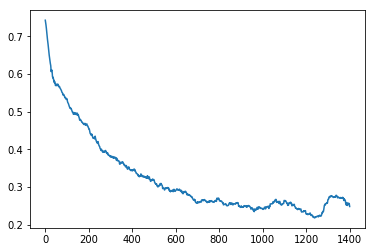

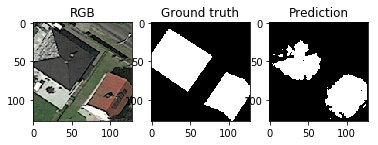

In [23]:
train(net, optimizer, 30, scheduler)

In [ ]:
train(net, optimizer, 1, scheduler)

### Testing the network

Now that the training has ended, we can load the final weights and test the network using a reasonable stride, e.g. half or a quarter of the window size. Inference time depends on the chosen stride, e.g. a step size of 32 (75% overlap) will take ~15 minutes, but no overlap will take only one minute or two.

In [24]:
net.load_state_dict(torch.load('./segnet_final'))

In [31]:
all_preds, test_input = test(net, test_ids, stride=128)

### Saving the results

We can visualize and save the resulting tiles for qualitative assessment.

/Users/sage/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/sage/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


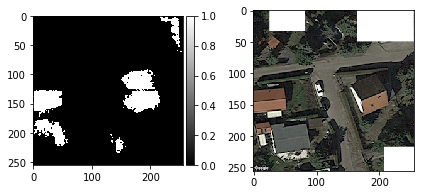

/Users/sage/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: ./inference_id_539.png is a low contrast image
  warn('%s is a low contrast image' % fname)


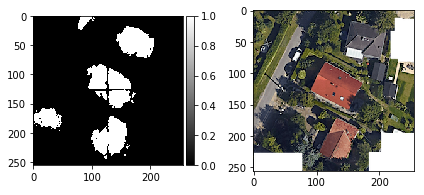

/Users/sage/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: ./inference_id_537.png is a low contrast image
  warn('%s is a low contrast image' % fname)


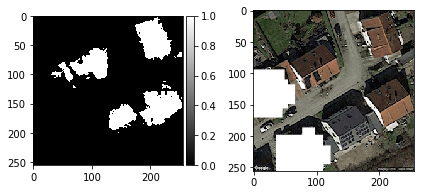

/Users/sage/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: ./inference_id_535.png is a low contrast image
  warn('%s is a low contrast image' % fname)


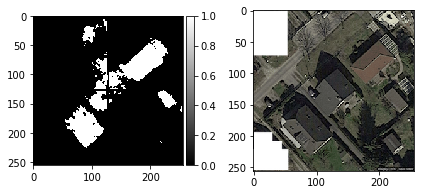

/Users/sage/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: ./inference_id_553.png is a low contrast image
  warn('%s is a low contrast image' % fname)


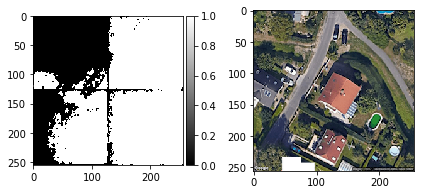

/Users/sage/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: ./inference_id_551.png is a low contrast image
  warn('%s is a low contrast image' % fname)


In [32]:
for img, test_img, id_ in zip(all_preds, test_input, test_ids):
    fig = plt.figure()
    fig.add_subplot(121)
    io.imshow(img,  cmap='gray')
    fig.add_subplot(122)
    io.imshow(test_img)
    plt.show()
    io.imsave('./inference_id_{}.png'.format(id_), 255*img)